In [1]:
# import seaborn as sns

# independent_feature = df['Category']
# dependent_feature = df['Price']

# sns.boxplot(data=df, x=independent_feature, y=dependent_feature)
# plt.xlabel('Independent Feature')
# plt.ylabel('Dependent Feature')
# plt.show()


In [2]:
# print("MAX: \n",pd.DataFrame(df.groupby('Category')['Price'].max()).sort_values(by='Price'),'\n\n',
#       "MIN: \n",pd.DataFrame(df.groupby('Category')['Price'].min()).sort_values(by='Price'))

Here I've distributed the label for each type of Category based on the box plot distribution of Category variable with Price and check for maximum and minimum price value of each column

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

data = pd.read_csv('laptops_train.csv')
data['GPU'].replace({'Nvidia GeForce GTX 960<U+039C>':'Nvidia GeForce GTX 960'}, inplace=True)
data['Operating System Version'] = data['Operating System Version'].fillna('NA')
df = data.copy()
df['Price'] = (df['Price'].astype(int)//100)
df.head()

,Manufacturer,Model Name,Category,Screen Size,Screen,CPU,RAM,Storage,GPU,Operating System,Operating System Version,Weight,Price
0,Apple,MacBook Pro,Ultrabook,"13.3""",IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,NA,1.37kg,119125
1,Apple,Macbook Air,Ultrabook,"13.3""",1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,NA,1.34kg,79933
2,HP,250 G6,Notebook,"15.6""",Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,NA,1.86kg,51129
3,Apple,MacBook Pro,Ultrabook,"15.4""",IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,NA,1.83kg,225630
4,Apple,MacBook Pro,Ultrabook,"13.3""",IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,NA,1.37kg,160376


In [4]:
df.duplicated().sum()

0

In [5]:
# 1. Drop Manufacturer and Model Name columns as it has large number of unique values that do not contribute to 
# their price
df.drop(columns=['Manufacturer', 'Model Name'],inplace=True)

# 2. Label encoding of Category column as each category has a different weightage
df['cat_type'] = df['Category'].replace({'Netbook':1, 'Notebook':2, '2 in 1 Convertible':3, 'Ultrabook':4, 
                                         'Workstation':5, 'Gaming':6 })

# 3. Extract Screen size number 
df['Screen Size'] = df['Screen Size'].str[:-1].astype(float)

# 4. Extract Screen resolution and Screen IPS/FHD/Retina display info in different columns and label encode it
Screen_Res = df['Screen'].apply(lambda x: ' ' + x if len(x.split()) == 1 else x)
Screen_Res = Screen_Res.str.split().str[-1]
df['Screen_Res'] = Screen_Res.astype('category').cat.codes

Screen_Disp = df['Screen'].apply(lambda x: '-1 ' + x if len(x.split()) == 1 else x)
df['Screen_Disp'] = Screen_Disp.str.rsplit(n=1, expand=True)[0]
df['Screen_Disp'].replace({'-1':0, 'Full HD':1, 'Full HD / Touchscreen':2, 'Touchscreen / Full HD':2,
                            'IPS Panel Full HD':3, 'IPS Panel Full HD / Touchscreen':4, 'Touchscreen':5,
                            'IPS Panel Touchscreen':6, 'IPS Panel':7, 'Quad HD+':8, 'Touchscreen / Quad HD+':9,
                            'IPS Panel Quad HD+':10, 'IPS Panel Quad HD+ / Touchscreen':11, '4K Ultra HD':12,
                            '4K Ultra HD / Touchscreen':13, 'IPS Panel 4K Ultra HD':14, 
                            'IPS Panel 4K Ultra HD / Touchscreen':15, 'IPS Panel Touchscreen / 4K Ultra HD':15,
                            'Quad HD+ / Touchscreen':16, 'IPS Panel Retina Display':17
                        },inplace=True)

# 5. Extract CPU version and clock speed in different columns
clock = df['CPU'].str.rsplit(n=1, expand=True)[1]
df['CPU_Clockspeed'] = clock.str[:-3].astype(float)

df['CPU_Manufacturer'] = df['CPU'].str.split().str[0]

cpu = df['CPU'].str.rsplit(n=1, expand=True)[0]

cpu = cpu.apply(lambda x: x + ' 0' if len(x.split()) == 3 else x)
cpu_industry = cpu.str.rsplit(n=1, expand=True)[0]
cpu_gen_perf = cpu.str.rsplit(n=1, expand=True)[1]

def split_alphanumeric_column(column):
    digits = ''
    characters = ''

    for char in column:
        if char.isdigit():
            digits += char
        else:
            characters += char

    return digits[0], characters, digits
df[['Generation', 'Performace', 'deleteLater']] = cpu_gen_perf.apply(split_alphanumeric_column).apply(pd.Series)
df['Generation'] = df['Generation'].astype(int)
df['Performace'].replace({'m':'M', 'm-Y':'M-Y', 'v':'V'}, inplace=True)
df['Performace'].replace({'':0, 'N':1, 'Y':2, 'M-Y':2.5, 'M':3, 'U':4, 'V':5, 'P':6, 'HQ':7, 'H':8, 'HK':9 },
                          inplace=True)
df.drop(columns=['deleteLater'], inplace=True)

Intel = df[df['CPU'].str.contains('Intel')]['CPU']
Intel = Intel.str.replace("-"," ")
Intel = Intel.str.replace("Dual", "i2")
Intel = Intel.str.replace("Quad", "i4")

df['Intel_Cores'] = Intel.str.split(" ").str[2].str[-1].replace("M","1").astype(int)
df['Intel_Cores'] = df['Intel_Cores'].fillna(0)

AMD = df[df['CPU'].str.contains("AMD")]['CPU']
AMD = AMD.str.replace("-"," ")
df['AMD_Cores'] = AMD.str.split().str[1]
df['AMD_Cores'] = df['AMD_Cores'].fillna(0)
df['AMD_Cores'].replace({'E':1, 'A4':2, 'A6':3, 'A8':4, 'A9':5, 'A10':6, 'A12':7, 'FX':8, 'Ryzen':9}, inplace=True)

# 6. Convert RAM to numeric
df["RAM"] = df["RAM"].str[:-2].astype(int)

# 7. Extract SSD and size of storage in different columns
storage_split = df[' Storage'].str.split()
storage_split = storage_split.apply(lambda x: x+['+','0GB','0'] if len(x) < 5 else x)

df['stor_size1'] = storage_split.str[0].replace({"1TB":"1024GB", "2TB":"2048GB", "508GB":"500GB"}).str[:-2].astype(int)
df['stor_type1'] = storage_split.str[1].replace({'HDD':1, 'Flash':3, 'SSD':4, 'Hybrid':2})
df['stor_size2'] = storage_split.str[-2].replace({"1TB":"1024GB", "2TB":"2048GB"}).str[:-2].astype(int)
df['stor_type2'] = storage_split.str[-1].replace({'0':0, 'HDD':1, 'Flash':3, 'SSD':4, 'Hybrid':2})

# 8. clean GPU data
nvidia = df[df['GPU'].str.contains("Nvidia")]['GPU']
amd = df[df['GPU'].str.contains("AMD")]['GPU']
intel = df[df['GPU'].str.contains("Intel")]['GPU']

df['GPU_Intel_Version'] = intel.str.rsplit(n=2).str[-1].replace({"Graphics":0}).astype(int)
df['GPU_Intel_Version'] = df['GPU_Intel_Version'].fillna(0).astype(int)

df['GPU_Intel_Chipset'] = intel.str.rsplit(n=2).str[0].replace({"Intel HD":1, 'Intel':1, 'Intel UHD':2, 
                                                                'Intel Iris':3, 'Intel Iris Plus':4})
df['GPU_Intel_Chipset'] = df['GPU_Intel_Chipset'].fillna(0).astype(int)

amd_split = amd.str.split()
amd_split = amd_split.apply(lambda x: x+['0','0'] if len(x)==2 else x+['0'] if len(x)==3 else x)
df1 = amd_split[~amd_split.str[1].str.contains("Radeon") & ~amd_split.str[1].str.contains("FirePro")].apply(lambda x: x[:1] + ["Radeon"] + x[1:-1])
amd_split.loc[83] = df1.loc[83]
amd_split.loc[178] = df1.loc[178]
df['GPU_AMD_Chipset'] = amd_split.str[1].replace({'Radeon':2, 'FirePro':1})
df['GPU_AMD_Chipset'] = df['GPU_AMD_Chipset'].fillna(0).astype(int)

amd_gen = amd_split.str[3]
amd_gen = amd_gen.replace({"Graphics":'0'})
df[['x','y','GPU_AMD_Version']] = amd_gen.apply(split_alphanumeric_column).apply(pd.Series)
df['GPU_AMD_Version'] = df['GPU_AMD_Version'].fillna(0).astype(int)
df.drop(columns=['x','y'], inplace=True)

nvidia1 = nvidia.str.split(n=1).str[1]
df['GPU_Nvidia_Chipset'] = nvidia1.apply(lambda x: 3 if 'RTX' in x else 2 if 'GTX' in x else 1)
df['GPU_Nvidia_Chipset'] = df['GPU_Nvidia_Chipset'].fillna(0).astype(int)

df[['x','y','GPU_Nvidia_Version']] = nvidia1.apply(split_alphanumeric_column).apply(pd.Series)
df['GPU_Nvidia_Version'] = df['GPU_Nvidia_Version'].fillna(0).astype(int)
df.drop(columns=['x','y'], inplace=True)

# 9. Label encode OS and OS versin column
df["Operating System"].replace({"macOS": "Mac OS"}, inplace=True)
df["Operating System"].replace({'Android':1, 'Chrome OS':2, 'Linux':3, 'No OS':4, 'Windows':5, 'Mac OS':5}, inplace=True)

df["Operating System Version"] = df["Operating System Version"].fillna(0)
df["Operating System Version"] = df["Operating System Version"].replace({'NA':0,'10 S':9, 'X':11}).astype(float)

# 10.Convert Weight to integer
df['Weight'] = df['Weight'].str[:-2].astype(float)

# 11.Perform EDA
# 12.Feature engineering
# 13.Model
# 14.Website
# 15.Deployment

In [6]:
df['stor_type2'].unique()

array([0, 1, 4])

In [7]:
df_raw = df.drop(columns=['Category','Screen','CPU',' Storage','GPU','CPU_Manufacturer'])
# df.drop(columns=['Operating System','Category','Screen','CPU',' Storage','GPU','CPU_Manufacturer',
#                           'Weight','Screen_Disp'])
df_raw.head()

,Screen Size,RAM,Operating System,Operating System Version,Weight,Price,cat_type,Screen_Res,Screen_Disp,CPU_Clockspeed,Generation,Performace,Intel_Cores,AMD_Cores,stor_size1,stor_type1,stor_size2,stor_type2,GPU_Intel_Version,GPU_Intel_Chipset,GPU_AMD_Chipset,GPU_AMD_Version,GPU_Nvidia_Chipset,GPU_Nvidia_Version
0,13.3,8,5,0.0,1.37,119125,4,10,17,2.3,0,0.0,5.0,0,128,4,0,0,640,4,0,0,0,0
1,13.3,8,5,0.0,1.34,79933,4,1,0,1.8,0,0.0,5.0,0,128,3,0,0,6000,1,0,0,0,0
2,15.6,8,4,0.0,1.86,51129,2,3,1,2.5,7,4.0,5.0,0,256,4,0,0,620,1,0,0,0,0
3,15.4,16,5,0.0,1.83,225630,4,12,17,2.7,0,0.0,7.0,0,512,4,0,0,0,0,2,455,0,0
4,13.3,8,5,0.0,1.37,160376,4,10,17,3.1,0,0.0,5.0,0,256,4,0,0,650,4,0,0,0,0


In [8]:
X = df_raw.drop(['Price'], axis=1)
y = df_raw['Price']

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.3, random_state = 0
)

X_train.shape, X_test.shape

((683, 23), (294, 23))

In [10]:
X_train.head()

,Screen Size,RAM,Operating System,Operating System Version,Weight,cat_type,Screen_Res,Screen_Disp,CPU_Clockspeed,Generation,Performace,Intel_Cores,AMD_Cores,stor_size1,stor_type1,stor_size2,stor_type2,GPU_Intel_Version,GPU_Intel_Chipset,GPU_AMD_Chipset,GPU_AMD_Version,GPU_Nvidia_Chipset,GPU_Nvidia_Version
425,15.6,8,5,10.0,2.62,6,3,3,2.8,7,7.0,7.0,0,128,4,1024,1,0,0,0,0,2,1050
285,15.6,12,5,10.0,2.15,2,3,4,2.7,7,4.0,7.0,0,1024,1,0,0,620,1,0,0,0,0
71,13.3,8,5,10.0,1.40,4,3,3,1.8,8,4.0,7.0,0,256,4,0,0,0,0,2,0,0,0
49,17.3,4,5,10.0,2.80,2,0,0,1.1,4,1.0,4.0,0,1024,1,0,0,0,0,0,0,1,920
654,15.6,4,4,0.0,1.86,2,0,0,2.0,6,4.0,3.0,0,500,1,0,0,520,1,0,0,0,0


In [11]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()


X_train = scalar.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=X.columns)

X_test = scalar.transform(X_test)
X_test = pd.DataFrame(X_test, columns=X.columns)

<AxesSubplot: >

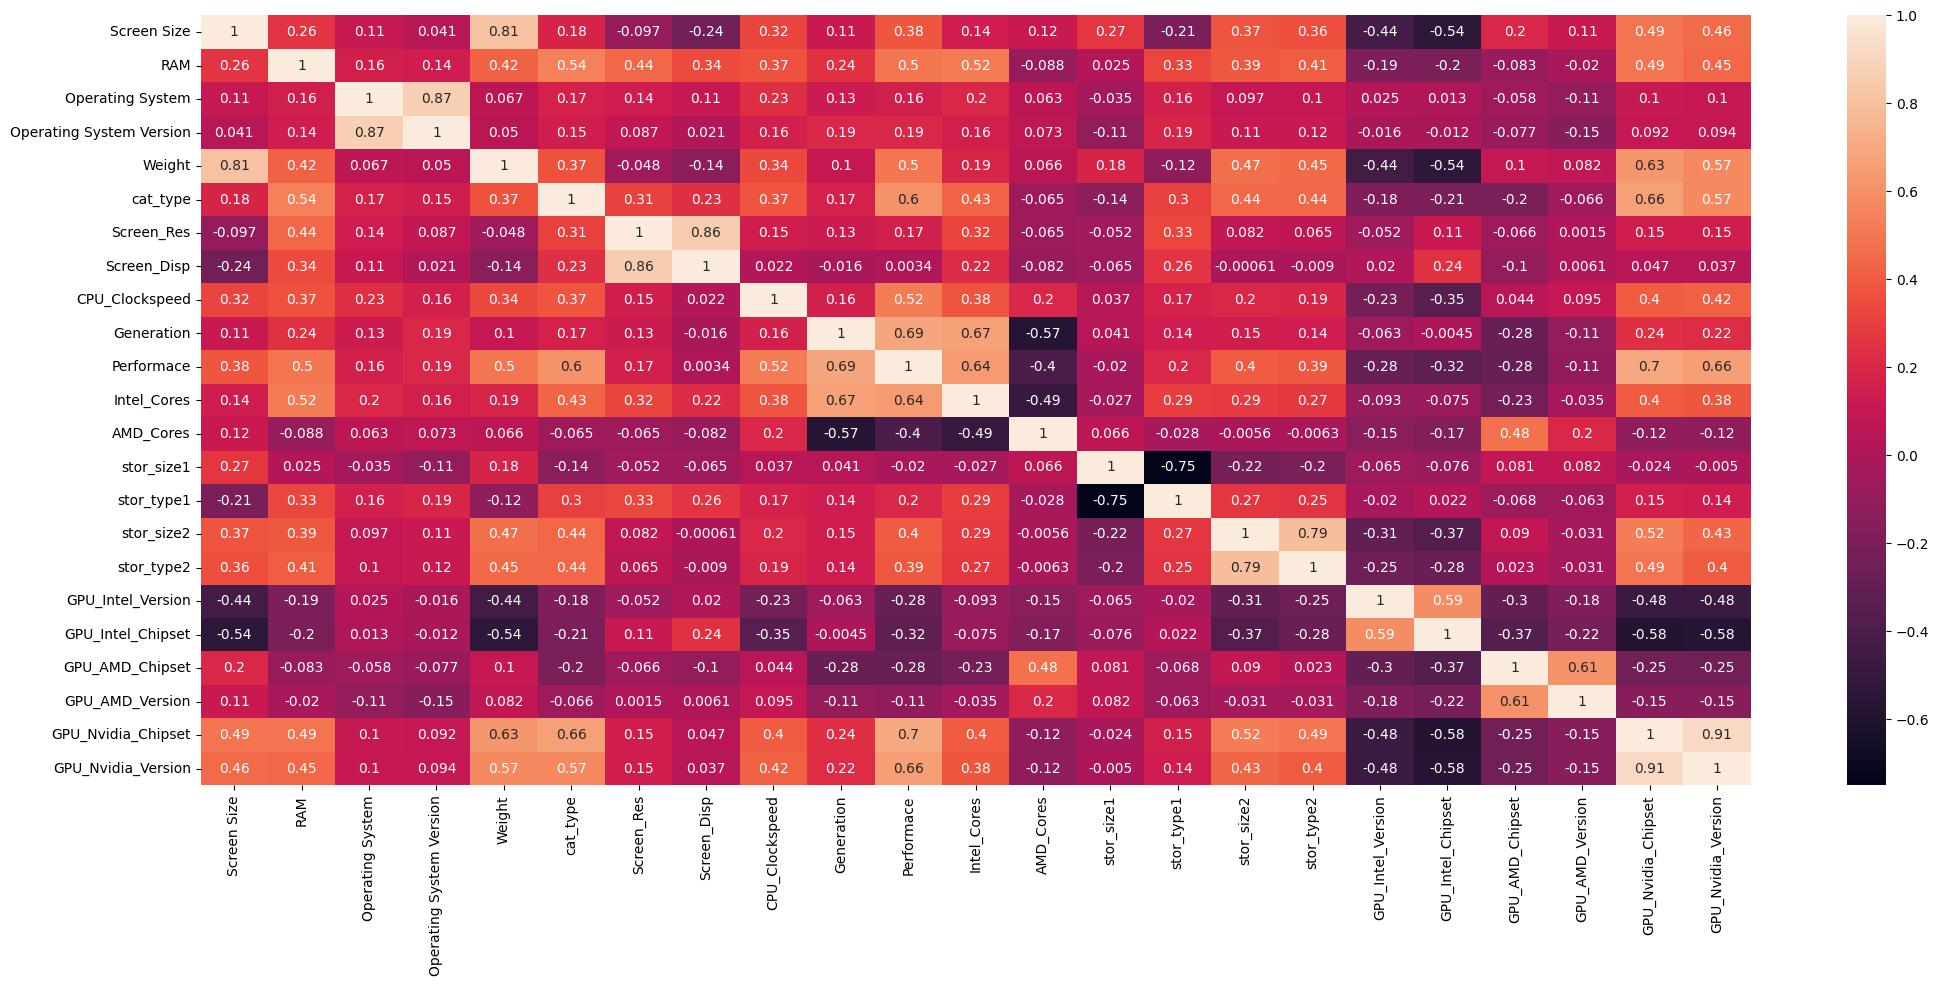

In [12]:
plt.figure(figsize=(25,10))
sns.heatmap(X_train.corr(), annot=True)

In [13]:
def correlation(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j] > threshold):
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [14]:
corr_features = correlation(X_train, 0.8)
len(set(corr_features))

4

In [15]:
corr_features

{'GPU_Nvidia_Version', 'Operating System Version', 'Screen_Disp', 'Weight'}

<AxesSubplot: >

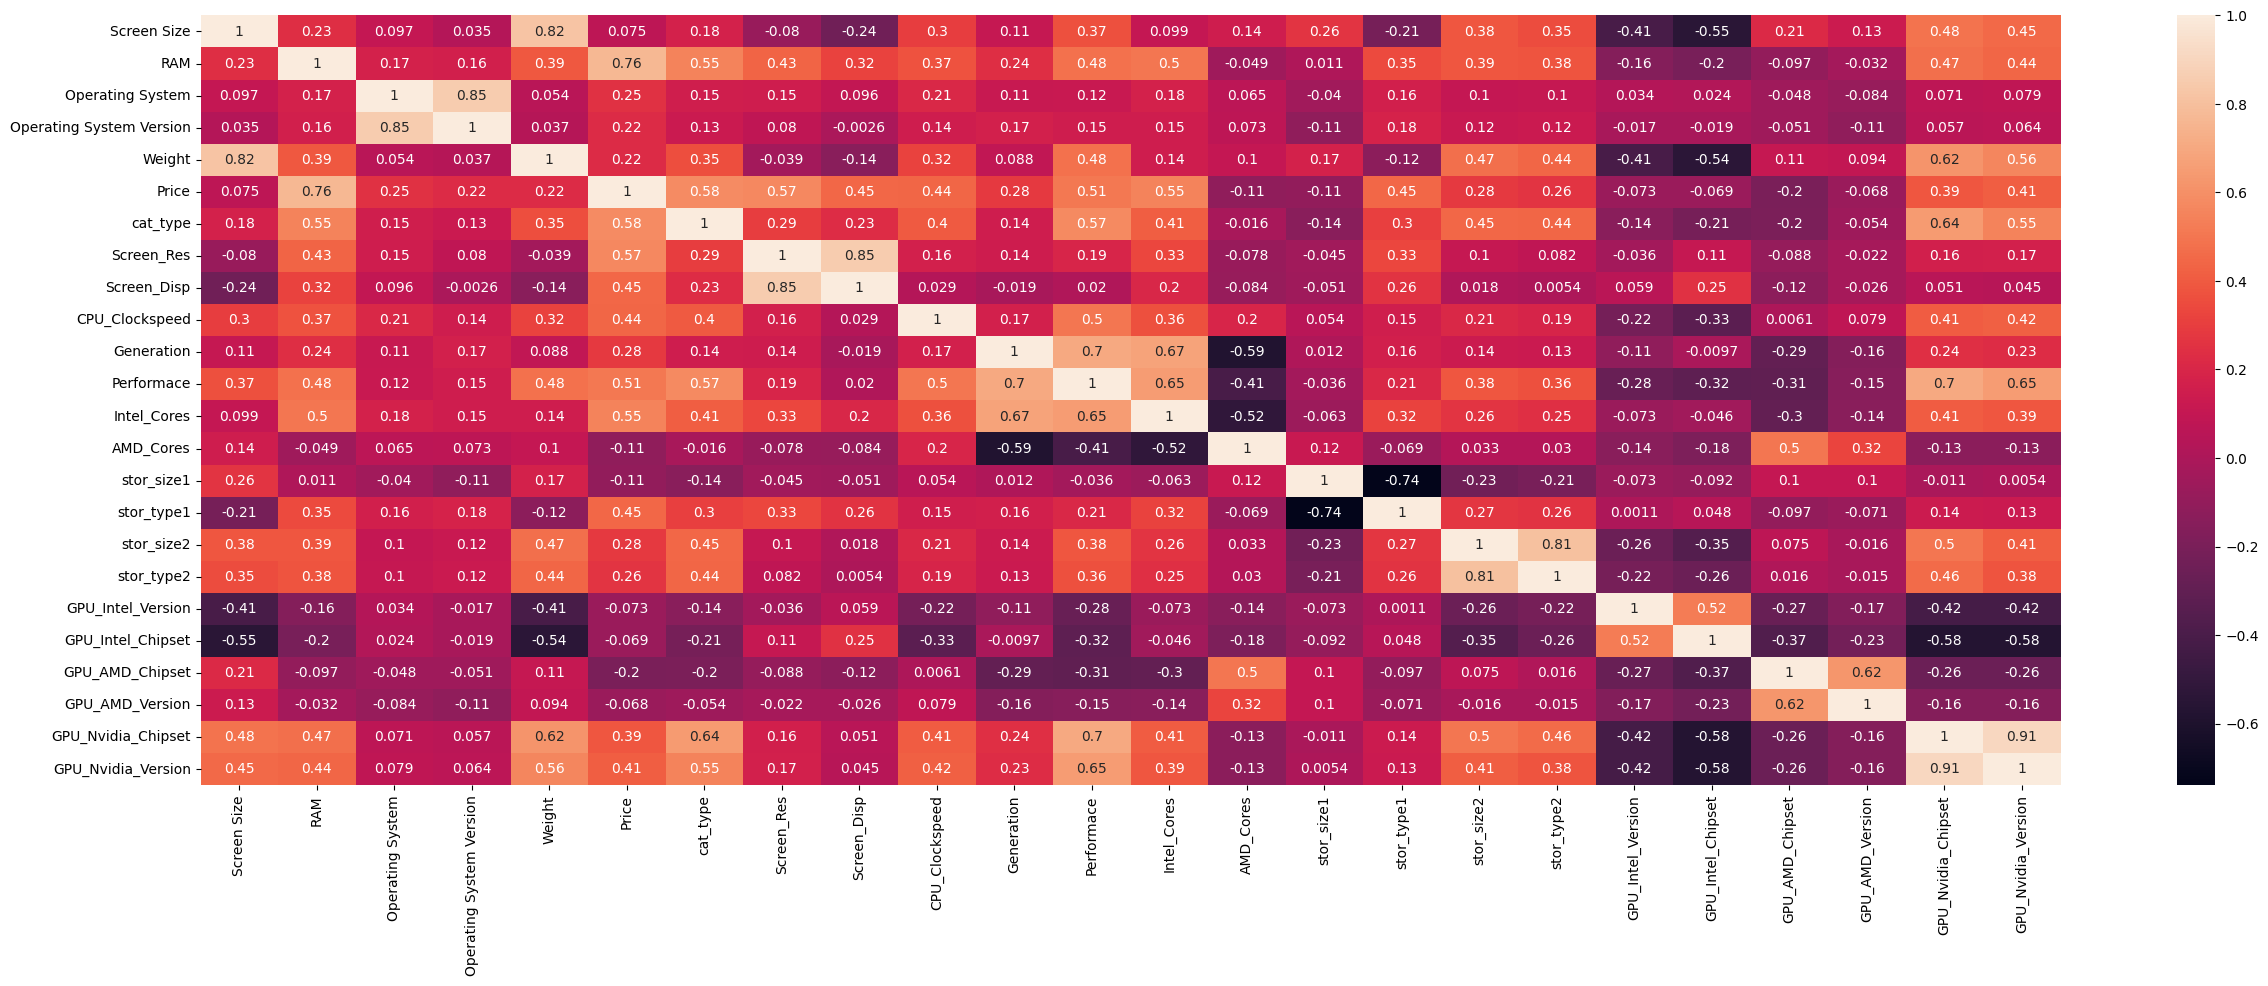

In [16]:
plt.figure(figsize=(30,10))
sns.heatmap(df_raw.corr(), annot=True)

In [17]:
corr_features = correlation(df_raw, 0.8)
len(set(corr_features))

5

In [18]:
corr_features

{'GPU_Nvidia_Version',
 'Operating System Version',
 'Screen_Disp',
 'Weight',
 'stor_type2'}

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, get_scorer_names, r2_score
import xgboost
# get_scorer_names()


In [20]:
models = {
    'Linear Regression': LinearRegression(),
#     'Logistic Regression': LogisticRegression(solver='lbfgs', max_iter=50),
    'Random Forest': RandomForestRegressor(),
    'XG Boost': xgboost.XGBRFRegressor()
}

In [21]:
for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train)
    
    mse_train = cross_val_score(model,X_train,y_train,scoring='neg_mean_squared_error', cv=5)
    mae_train = cross_val_score(model,X_train,y_train,scoring='neg_mean_absolute_error', cv=5)
    rmse_train = cross_val_score(model,X_train,y_train,scoring='neg_root_mean_squared_error', cv=5)
   
    mse_test = cross_val_score(model,X_test,y_test,scoring='neg_mean_squared_error', cv=5)
    mae_test = cross_val_score(model,X_test,y_test,scoring='neg_mean_absolute_error', cv=5)
    rmse_test = cross_val_score(model,X_test,y_test,scoring='neg_root_mean_squared_error', cv=5)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    print(list(models.keys())[i])
    print("******** Training **********")
    print("MSE : ", np.mean(mse_train))
    print("MAE : ", np.mean(mae_train))
    print("RMSE: ", np.mean(rmse_train))
    
#     plt.figure(figsize=(1,0.05))
#     sns.displot(y_train_pred-y_train, kind='kde')
#     plt.show()
    print("\nScore: ", r2_score(y_train_pred, y_train))
    print("\n******** Testing **********")
    print("MSE : ", mean_squared_error(y_test,y_test_pred))
    print(np.mean(mse_test))
    print("MAE : ", mean_absolute_error(y_test, y_test_pred))
    print(np.mean(mae_test))
    print("RMSE: ", mean_squared_error(y_test,y_test_pred,squared=False))
    print(np.mean(rmse_test))
    
#     plt.figure(figsize=(1,1))
#     sns.displot(y_test_pred-y_test, kind='kde')
#     plt.show()
    print("\nScore: ", r2_score(y_test_pred, y_test))
    print("************************************************\n")
    
    

Linear Regression
******** Training **********
MSE :  -1060139568.6389046
MAE :  -23756.41169962543
RMSE:  -32466.513806709903

Score:  0.6757803586085538

******** Testing **********
MSE :  906009447.8981202
-942861299.3734967
MAE :  21736.492996982277
-21914.218771649408
RMSE:  30099.990828871032
-30056.249268962787

Score:  0.7210246282805399
************************************************

Random Forest
******** Training **********
MSE :  -685533601.0633833
MAE :  -16213.188232018136
RMSE:  -26059.277829610797

Score:  0.9774849350074821

******** Testing **********
MSE :  451632393.63942057
-887811954.9681299
MAE :  15133.72612988608
-18399.679417216328
RMSE:  21251.644492589756
-28726.65604506665

Score:  0.8709545529298823
************************************************

XG Boost
******** Training **********
MSE :  -790956143.9085814
MAE :  -17893.104366521646
RMSE:  -27837.090661649214

Score:  0.8999703333782049

******** Testing **********
MSE :  574781802.1349846
-93629378

In [22]:
lr_params = {
    'fit_intercept': [True, False],
    'copy_X'       : [True, False],
    'n_jobs'       : [1,2,3,4,5],
    'positive'     : [True, False]
}

rf_params = {
#     'n_estimators'     : [1,10,100],
#     'criterion'        : ['absolute_error', 'squared_error', 'poisson'],
#     'max_depth'        : [2,4,6],
#     'min_samples_split': [1,3,5],
#     'min_samples_leaf' : [1,2,3],
#     'oob_score'        : [True, False],
#     'n_jobs'           : [1,2,3],
#     'max_samples'      : [5,7,9]
}

xg_params = {
    'learning_rate'   : [0.05,0.1,0.15,0.2,0.25,0.3],
    'gamma'           : [0,0.1,0.2,0.3,0.4],
    'max_depth'       : [3,4,5,6,8,10,12,15],
    'min_child_weight': [1,3,5,7],
    'colsample_bytree': [0.3,0.4,0.5,0.7]
}

In [23]:
randomcv_models = [
    ("Linear Regression",LinearRegression(), lr_params),
    ("Random Forest",RandomForestRegressor(), rf_params),
    ("XG Boost",xgboost.XGBRFRegressor(), xg_params)
]

In [24]:
model_params = {}
for name, model, params in randomcv_models:
    random = RandomizedSearchCV(estimator=model,
                               param_distributions=params,
                               n_jobs=2,
                               cv=5,
                               n_iter=10,
                               verbose=2)
    random.fit(X_train,y_train)
    model_params[name] = random.best_params_
    
for model_name in model_params:
    print('************** Best Parameters for {} *****************'.format(model_name))
    print(model_params[model_name],"\n")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/jacksonbawa/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
************** Best Parameters for Linear Regression *****************
{'positive': False, 'n_jobs': 4, 'fit_intercept': True, 'copy_X': True} 

************** Best Parameters for Random Forest *****************
{} 

************** Best Parameters for XG Boost *****************
{'min_child_weight': 5, 'max_depth': 6, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.5} 



In [25]:
HPtuned_models = {
    'Linear Regression': LinearRegression(
        positive=False,
        n_jobs=4,
        fit_intercept=True,
        copy_X=False
    ),
#     'Logistic Regression': LogisticRegression(solver='lbfgs', max_iter=50),
    'Random Forest': RandomForestRegressor(
#         oob_score=False,
#         n_jobs=2,
#         n_estimators=1000,
#         min_samples_split=5,
#         min_samples_leaf=3,
#         max_samples=9,
#         max_depth=8,
#         criterion='po
    ),
    'XG Boost': xgboost.XGBRFRegressor(
        min_child_weight=2,
        max_depth=7,
        learning_rate=1,
        gamma=10,
        alpha=0.1,
    )
}

In [26]:
for i in range(len(list(HPtuned_models))):
    model = list(HPtuned_models.values())[i]
    model.fit(X_train, y_train)
    
    mse_train = cross_val_score(model,X_train,y_train,scoring='neg_mean_squared_error', cv=5)
    mae_train = cross_val_score(model,X_train,y_train,scoring='neg_mean_absolute_error', cv=5)
    rmse_train = cross_val_score(model,X_train,y_train,scoring='neg_root_mean_squared_error', cv=5)
   
    mse_test = cross_val_score(model,X_test,y_test,scoring='neg_mean_squared_error', cv=5)
    mae_test = cross_val_score(model,X_test,y_test,scoring='neg_mean_absolute_error', cv=5)
    rmse_test = cross_val_score(model,X_test,y_test,scoring='neg_root_mean_squared_error', cv=5)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    print(list(HPtuned_models.keys())[i])
    print("******** Training **********")
    print("MSE : ", np.mean(mse_train))
    print("MAE : ", np.mean(mae_train))
    print("RMSE: ", np.mean(rmse_train))
    print("Score: ", r2_score(y_train_pred, y_train))
#     plt.figure(figsize=(1,0.05))
#     sns.displot(y_train_pred-y_train, kind='kde')
#     plt.show()
    
    print("\n******** Testing **********")
    print("MSE : ", mean_squared_error(y_test,y_test_pred))
    print(np.mean(mse_test))
    print("MAE : ", mean_absolute_error(y_test, y_test_pred))
    print(np.mean(mae_test))
    print("RMSE: ", mean_squared_error(y_test,y_test_pred,squared=False))
    print(np.mean(rmse_test))
    print("Score: ", r2_score(y_test_pred, y_test))
#     plt.figure(figsize=(1,1))
#     sns.displot(y_test_pred-y_test, kind='kde')
#     plt.show()
    print("************************************************\n")

Linear Regression
******** Training **********
MSE :  -1060139568.6389043
MAE :  -23756.411699625427
RMSE:  -32466.513806709892
Score:  0.6757803586085538

******** Testing **********
MSE :  906009447.8981202
-942861299.3734967
MAE :  21736.492996982277
-21914.218771649408
RMSE:  30099.990828871032
-30056.249268962787
Score:  0.7210246282805399
************************************************

Random Forest
******** Training **********
MSE :  -687569617.2838563
MAE :  -16142.022313544416
RMSE:  -26324.668342067995
Score:  0.9736119180634925

******** Testing **********
MSE :  489853445.78330815
-892816303.5617491
MAE :  15309.456933916426
-18321.32765710946
RMSE:  22132.633051295732
-28955.4079606674
Score:  0.8585600836722248
************************************************

XG Boost
******** Training **********
MSE :  -770136662.3828827
MAE :  -17165.684656752324
RMSE:  -27473.28985432008
Score:  0.9155531721335062

******** Testing **********
MSE :  571087113.2401384
-906125275.4122

Random Forest without Hyperparameter Tuning gives better accuracy.
XG Boost after Hyperparameter Tuning gives better accuracy.
Linear Regression with or without Hyperparameter tuning gives same accuracy

In [27]:
# XG Boost
#           After                                  Before                                Parameters
# ******** Training **********           ******** Training **********           'XG Boost': xgboost.XGBRFRegressor(
# MSE :  -770136662.3828827              MSE :  -790956143.9085814                      min_child_weight=2,
# MAE :  -17165.684656752324             MAE :  -17893.104366521646                     max_depth=7,
# RMSE:  -27473.28985432008              RMSE:  -27837.090661649214                     learning_rate=1,
# Score:  0.9155531721335062             Score:  0.8999703333782049                     gamma=10,
#                                                                                       alpha=0.1)
# ******** Testing **********            ******** Testing **********
# MSE :  -906125275.4122105              MSE :  -936293782.0322254
# MAE :  -18712.214880164196             MAE :  -19023.253113699044
# RMSE:  -28825.563084557245             RMSE:  -29376.585932435504
# Score:  0.8282261333319062             Score:  0.8232032503643205

# Random Forest (Better without Hyperparameter optimization)
# ******** Training **********
# MSE :  -695069484.7641418
# MAE :  -16076.985734649808
# RMSE:  -26398.044998796657
# Score:  0.9750978755810267

# ******** Testing **********
# MSE :  -901856039.263084
# MAE :  -18138.170555659457
# RMSE:  -28692.970501412365
# Score:  0.8629073081845343

In [28]:
df_test = pd.read_csv("laptops_test.csv")
df_test['GPU'].replace({'Nvidia GeForce GTX 960<U+039C>':'Nvidia GeForce GTX 960'}, inplace=True)
df_test['Weight'].replace({'4kgs':'4kg'}, inplace=True)
df_test['Operating System Version'] = df_test['Operating System Version'].fillna('NA')
df_test['Price'] = (df_test['Price'].astype(int)//100)
df = df_test.copy()
df.head()

,Manufacturer,Model Name,Category,Screen Size,Screen,CPU,RAM,Storage,GPU,Operating System,Operating System Version,Weight,Price
0,HP,15-bs053od (i7-7500U/6GB/1TB/W10),Notebook,"15.6""",1366x768,Intel Core i7 7500U 2.7GHz,6GB,1TB HDD,Intel HD Graphics 620,Windows,10,2.04kg,51484
1,Asus,Rog GL753VE-DS74,Gaming,"17.3""",Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1050 Ti,Windows,10,2.99kg,155521
2,Dell,Inspiron 7579,2 in 1 Convertible,"15.6""",IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i7 7500U 2.7GHz,12GB,512GB SSD,Intel HD Graphics 620,Windows,10,2.19kg,115507
3,Toshiba,Portege Z30-C-1CV,Notebook,"13.3""",Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,4GB,128GB SSD,Intel HD Graphics 520,Windows,7,1.2kg,106259
4,Lenovo,IdeaPad 320-15ABR,Notebook,"15.6""",Full HD 1920x1080,AMD A12-Series 9720P 3.6GHz,6GB,256GB SSD,AMD Radeon 530,Windows,10,2.2kg,48817


In [29]:
df.drop_duplicates(inplace=True)

In [30]:
# 1. Drop Manufacturer and Model Name columns as it has large number of unique values that do not contribute to 
# their price
df.drop(columns=['Manufacturer', 'Model Name'],inplace=True)

# 2. Label encoding of Category column as each category has a different weightage
df['cat_type'] = df['Category'].replace({'Netbook':1, 'Notebook':2, '2 in 1 Convertible':3, 'Ultrabook':4, 
                                         'Workstation':5, 'Gaming':6 })

# 3. Extract Screen size number 
df['Screen Size'] = df['Screen Size'].str[:-1].astype(float)

# 4. Extract Screen resolution and Screen IPS/FHD/Retina display info in different columns and label encode it
Screen_Res = df['Screen'].apply(lambda x: ' ' + x if len(x.split()) == 1 else x)
Screen_Res = Screen_Res.str.split().str[-1]
df['Screen_Res'] = Screen_Res.astype('category').cat.codes

Screen_Disp = df['Screen'].apply(lambda x: '-1 ' + x if len(x.split()) == 1 else x)
df['Screen_Disp'] = Screen_Disp.str.rsplit(n=1, expand=True)[0]
df['Screen_Disp'].replace({'-1':0, 'Full HD':1, 'Full HD / Touchscreen':2, 'Touchscreen / Full HD':2,
                            'IPS Panel Full HD':3, 'IPS Panel Full HD / Touchscreen':4, 'Touchscreen':5,
                            'IPS Panel Touchscreen':6, 'IPS Panel':7, 'Quad HD+':8, 'Touchscreen / Quad HD+':9,
                            'IPS Panel Quad HD+':10, 'IPS Panel Quad HD+ / Touchscreen':11, '4K Ultra HD':12,
                            '4K Ultra HD / Touchscreen':13, 'IPS Panel 4K Ultra HD':14, 
                            'IPS Panel 4K Ultra HD / Touchscreen':15, 'IPS Panel Touchscreen / 4K Ultra HD':15,
                            'Quad HD+ / Touchscreen':16, 'IPS Panel Retina Display':17
                        },inplace=True)

# 5. Extract CPU version and clock speed in different columns
clock = df['CPU'].str.rsplit(n=1, expand=True)[1]
df['CPU_Clockspeed'] = clock.str[:-3].astype(float)

df['CPU_Manufacturer'] = df['CPU'].str.split().str[0]

cpu = df['CPU'].str.rsplit(n=1, expand=True)[0]

cpu = cpu.apply(lambda x: x + ' 0' if len(x.split()) == 3 else x)
cpu_industry = cpu.str.rsplit(n=1, expand=True)[0]
cpu_gen_perf = cpu.str.rsplit(n=1, expand=True)[1]

def split_alphanumeric_column(column):
    digits = ''
    characters = ''

    for char in column:
        if char.isdigit():
            digits += char
        else:
            characters += char

    return digits[0], characters, digits
df[['Generation', 'Performace', 'deleteLater']] = cpu_gen_perf.apply(split_alphanumeric_column).apply(pd.Series)
df['Generation'] = df['Generation'].astype(int)
df['Performace'].replace({'m':'M', 'm-Y':'M-Y', 'v':'V'}, inplace=True)
df['Performace'].replace({'':0, 'N':1, 'Y':2, 'M-Y':2.5, 'M':3, 'U':4, 'V':5, 'P':6, 'HQ':7, 'H':8, 'HK':9 },
                          inplace=True)
df.drop(columns=['deleteLater'], inplace=True)

Intel = df[df['CPU'].str.contains('Intel')]['CPU']
Intel = Intel.str.replace("-"," ")
Intel = Intel.str.replace("Dual", "i2")
Intel = Intel.str.replace("Quad", "i4")

df['Intel_Cores'] = Intel.str.split(" ").str[2].str[-1].replace("M","1").astype(int)
df['Intel_Cores'] = df['Intel_Cores'].fillna(0)

AMD = df[df['CPU'].str.contains("AMD")]['CPU']
AMD = AMD.str.replace("-"," ")
df['AMD_Cores'] = AMD.str.split().str[1]
df['AMD_Cores'] = df['AMD_Cores'].fillna(0)
df['AMD_Cores'].replace({'E':1, 'A4':2, 'A6':3, 'A8':4, 'A9':5, 'A10':6, 'A12':7, 'FX':8, 'Ryzen':9}, inplace=True)

# 6. Convert RAM to numeric
df["RAM"] = df["RAM"].str[:-2].astype(int)

# 7. Extract SSD and size of storage in different columns
storage_split = df[' Storage'].str.split()
storage_split = storage_split.apply(lambda x: x+['+','0GB','0'] if len(x) < 5 else x)

df['stor_size1'] = storage_split.str[0].replace({"1TB":"1024GB", "2TB":"2048GB", "508GB":"500GB"}).str[:-2].astype(int)
df['stor_type1'] = storage_split.str[1].replace({'HDD':1, 'Flash':3, 'SSD':4, 'Hybrid':2})
df['stor_size2'] = storage_split.str[-2].replace({"1TB":"1024GB", "2TB":"2048GB"}).str[:-2].astype(int)
df['stor_type2'] = storage_split.str[-1].replace({'0':0, 'HDD':1, 'Flash':3, 'SSD':4, 'Hybrid':2})

# 8. clean GPU data
nvidia = df[df['GPU'].str.contains("Nvidia")]['GPU']
amd = df[df['GPU'].str.contains("AMD")]['GPU']
intel = df[df['GPU'].str.contains("Intel")]['GPU']

df['GPU_Intel_Version'] = intel.str.rsplit(n=2).str[-1].replace({"Graphics":0}).astype(int)
df['GPU_Intel_Version'] = df['GPU_Intel_Version'].fillna(0).astype(int)

df['GPU_Intel_Chipset'] = intel.str.rsplit(n=2).str[0].replace({"Intel HD":1, 'Intel':1, 'Intel UHD':2, 
                                                                'Intel Iris':3, 'Intel Iris Plus':4})
df['GPU_Intel_Chipset'] = df['GPU_Intel_Chipset'].fillna(0).astype(int)

amd_split = amd.str.split()
amd_split = amd_split.apply(lambda x: x+['0','0'] if len(x)==2 else x+['0'] if len(x)==3 else x)

df['GPU_AMD_Chipset'] = amd_split.str[1].replace({'Radeon':2, 'FirePro':1})
df['GPU_AMD_Chipset'] = df['GPU_AMD_Chipset'].fillna(0).astype(int)

amd_gen = amd_split.str[3]
amd_gen = amd_gen.replace({"Graphics":'0'})
df[['x','y','GPU_AMD_Version']] = amd_gen.apply(split_alphanumeric_column).apply(pd.Series)
df['GPU_AMD_Version'] = df['GPU_AMD_Version'].fillna(0).astype(int)
df.drop(columns=['x','y'], inplace=True)

nvidia1 = nvidia.str.split(n=1).str[1]
df['GPU_Nvidia_Chipset'] = nvidia1.apply(lambda x: 3 if 'RTX' in x else 2 if 'GTX' in x else 1)
df['GPU_Nvidia_Chipset'] = df['GPU_Nvidia_Chipset'].fillna(0).astype(int)

df[['x','y','GPU_Nvidia_Version']] = nvidia1.apply(split_alphanumeric_column).apply(pd.Series)
df['GPU_Nvidia_Version'] = df['GPU_Nvidia_Version'].fillna(0).astype(int)
df.drop(columns=['x','y'], inplace=True)

# 9. Label encode OS and OS versin column
df["Operating System"].replace({"macOS": "Mac OS"}, inplace=True)
df["Operating System"].replace({'Android':1, 'Chrome OS':2, 'Linux':3, 'No OS':4, 'Windows':5, 'Mac OS':5}, inplace=True)

df["Operating System Version"] = df["Operating System Version"].fillna(0)
df["Operating System Version"] = df["Operating System Version"].replace({'NA':0,'10 S':9, 'X':11}).astype(float)

# 10.Convert Weight to integer
df['Weight'] = df['Weight'].str[:-2].astype(float)

# 11.Perform EDA
# 12.Feature engineering
# 13.Model
# 14.Website
# 15.Deployment

In [31]:
df_raw_test = df.drop(columns=['Category','Screen','CPU',' Storage','GPU','CPU_Manufacturer'])
# df.drop(columns=['Operating System','Category','Screen','CPU',' Storage','GPU','CPU_Manufacturer',
#                           'Weight','Screen_Disp'])
df_raw_test.head()

,Screen Size,RAM,Operating System,Operating System Version,Weight,Price,cat_type,Screen_Res,Screen_Disp,CPU_Clockspeed,Generation,Performace,Intel_Cores,AMD_Cores,stor_size1,stor_type1,stor_size2,stor_type2,GPU_Intel_Version,GPU_Intel_Chipset,GPU_AMD_Chipset,GPU_AMD_Version,GPU_Nvidia_Chipset,GPU_Nvidia_Version
0,15.6,6,5,10.0,2.04,51484,2,0,0,2.7,7,4,7.0,0,1024,1,0,0,620,1,0,0,0,0
1,17.3,16,5,10.0,2.99,155521,6,2,1,2.8,7,7,7.0,0,256,4,1024,1,0,0,0,0,2,1050
2,15.6,12,5,10.0,2.19,115507,3,2,4,2.7,7,4,7.0,0,512,4,0,0,620,1,0,0,0,0
3,13.3,4,5,7.0,1.20,106259,2,2,1,2.3,6,4,5.0,0,128,4,0,0,520,1,0,0,0,0
4,15.6,6,5,10.0,2.20,48817,2,2,1,3.6,0,0,0.0,7,256,4,0,0,0,0,2,0,0,0


In [32]:
X = df_raw.drop(['Price'], axis=1)
y = df_raw['Price']

In [33]:
X = scalar.transform(X)
X = pd.DataFrame(X, columns=df_raw.drop(['Price'], axis=1).columns)

In [34]:
test_models = {
    'Random Forest': RandomForestRegressor(),
    'XG Boost': xgboost.XGBRFRegressor(
        min_child_weight=2,
        max_depth=7,
        learning_rate=1,
        gamma=10,
        alpha=0.1,
    )
}

In [35]:
import pickle

In [42]:
for i in range(len(list(test_models))):
    model = list(test_models.values())[i]
    model.fit(X_train, y_train)
    
#     mse_train = cross_val_score(model,X_train,y_train,scoring='neg_mean_squared_error', cv=5)
#     mae_train = cross_val_score(model,X_train,y_train,scoring='neg_mean_absolute_error', cv=5)
#     rmse_train = cross_val_score(model,X_train,y_train,scoring='neg_root_mean_squared_error', cv=5)
   
    mse_test = cross_val_score(model,X,y,scoring='neg_mean_squared_error', cv=5)
    mae_test = cross_val_score(model,X,y,scoring='neg_mean_absolute_error', cv=5)
    rmse_test = cross_val_score(model,X,y,scoring='neg_root_mean_squared_error', cv=5)

#     y_train_pred = model.predict(X_train)
    y_pred = model.predict(X)
    
    print(list(test_models.keys())[i])
#     print("******** Training **********")
#     print("MSE : ", np.mean(mse_train))
#     print("MAE : ", np.mean(mae_train))
#     print("RMSE: ", np.mean(rmse_train))
#     print("Score: ", r2_score(y_train_pred, y_train))
#     plt.figure(figsize=(1,0.05))
#     sns.displot(y_train_pred-y_train, kind='kde')
#     plt.show()
    
    print("\n******** Testing **********")
    print("MSE : ", np.mean(mse_test))
    print("MAE : ", np.mean(mae_test))
    print("RMSE: ", np.mean(rmse_test))
    print("Score: ", r2_score(y_pred, y))
#     plt.figure(figsize=(1,1))
#     sns.displot(y_pred-y, kind='kde')
#     plt.show()
    print("************************************************\n")
    
    pickle.dump(model, open("{}.pkl".format(list(test_models.keys())[i]), 'wb'))

Random Forest

******** Testing **********
MSE :  -618059390.918751
MAE :  -16444.622758015314
RMSE:  -24524.079539030536
Score:  0.9401037058471459
************************************************

XG Boost

******** Testing **********
MSE :  -695814803.3743689
MAE :  -17866.55473431981
RMSE:  -25966.523989903137
Score:  0.8891189535468853
************************************************

